# ELEC474 Prelab5

In [752]:
import cv2 as cv
import numpy as np
import random
import math
import time
from matplotlib import pyplot as plt

In [753]:
global my_SIFT_instance
my_SIFT_instance = cv.SIFT_create()


FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

img1Name = "tape_l.jpg"
img2Name = "tape_r.jpg"
img3Name = "coaster_left.jpg"
img4Name = "coaster_right.jpg"
img5Name = "bike_l.png"
img6Name = "bike_r.png"
# img3Name = "test1.jpg"
# img4Name = "test2.jpg"

img1 = cv.imread(img1Name)
img2 = cv.imread(img2Name)
img3 = cv.imread(img3Name)
img4 = cv.imread(img4Name)
img5 = cv.imread(img5Name)
img6 = cv.imread(img6Name)

imgDescipt_1 = np.array((
"Left Image",
"Right Imgae"
))


# 1.1

In [754]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)
        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

In [755]:
def SIFTOut(img, flag): #if flag == 1, then do gray
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        
    imgKpOut = np.copy(imgGray)
    kp, des = my_SIFT_instance.detectAndCompute(imgGray,None)
    imgKpOut = cv.drawKeypoints(imgKpOut,kp,0)
    return (imgKpOut,kp,des)

def FlannBasedMatchLoweRatio(img1Param,img2Param,
                            index_param,search_param,
                            kNum, ratio):
    img1Kp = img1Param[1]
    img2Kp = img2Param[1]
    flann = cv.FlannBasedMatcher(index_param,search_param)
    matches = flann.knnMatch(img1Param[2],img2Param[2],k = kNum)

    loweMatch = []
    loweImg1Point = []
    loweImg2Point = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append([m])
            loweImg1Point.append(img1Kp[m.queryIdx].pt) #NOTE: append requried left and right points  
            loweImg2Point.append(img2Kp[m.trainIdx].pt)

    imgOut = cv.drawMatchesKnn(img1Param[0],img1Kp,img2Param[0],img2Kp,loweMatch,None,flags=2)
    return imgOut, loweMatch, loweImg1Point, loweImg2Point

In [756]:
def Matching(img1, img2, flag):
    outImages = []
    keyPoints = []
    descriptors = []
    img1Param = SIFTOut(img1, flag)
    img2Param = SIFTOut(img2, flag)

    #FLANN param 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    # search_params = dict(checks = 100)
    flannOutImg, Matches, leftPoint, rightPoint = FlannBasedMatchLoweRatio(img1Param, img2Param,
                            index_params, search_params,
                            kNum = 2, ratio = 0.65)  #NOTE: The ratio difference of lowe will result in different epiploar lines 

    #classify params 
    outImages.append(img1Param[0])
    outImages.append(img2Param[0])
    # outImages.append(flannOutImg)

    keyPoints.append(img1Param[1])
    keyPoints.append(img2Param[1])

    descriptors.append(img1Param[2])
    descriptors.append(img2Param[2])
    #Plt to check
    # PltImg(outImages, imgDescipt_1)

    return keyPoints,descriptors,Matches, leftPoint, rightPoint

In [757]:
def FundamentalMatrixCal(img1, img2):
    point1 = []
    point2 = []
    _,_,_,point1,point2 = Matching(img1, img2, flag = 1)
    point1 = np.int32(point1)
    point2 = np.int32(point2)
    F, mask = cv.findFundamentalMat(point1, point2, cv.FM_LMEDS)

    return F, point1.flatten(), point2.flatten()

# 1.2

In [758]:
def ImgRectification(img1, img2):
    outImg = []
    imgSize = [img1.shape[0], img1.shape[1]]
    imgSizeRev = [img1.shape[1], img1.shape[0]]
    
    F, pts1, pts2 = FundamentalMatrixCal(img1, img2)
    _, h1, h2 = cv.stereoRectifyUncalibrated(pts1, pts2,F,imgSize, threshold = 10)
    outR = cv.warpPerspective(cv.cvtColor(img1, cv.COLOR_BGR2GRAY),h1,imgSizeRev, borderValue = (0,0,0))
    outL = cv.warpPerspective(cv.cvtColor(img2, cv.COLOR_BGR2GRAY),h2,imgSizeRev, borderValue = (0,0,0))
    #Plt test
    outImg.append(outR)
    outImg.append(outL)
    return outImg

<Figure size 1800x1200 with 0 Axes>

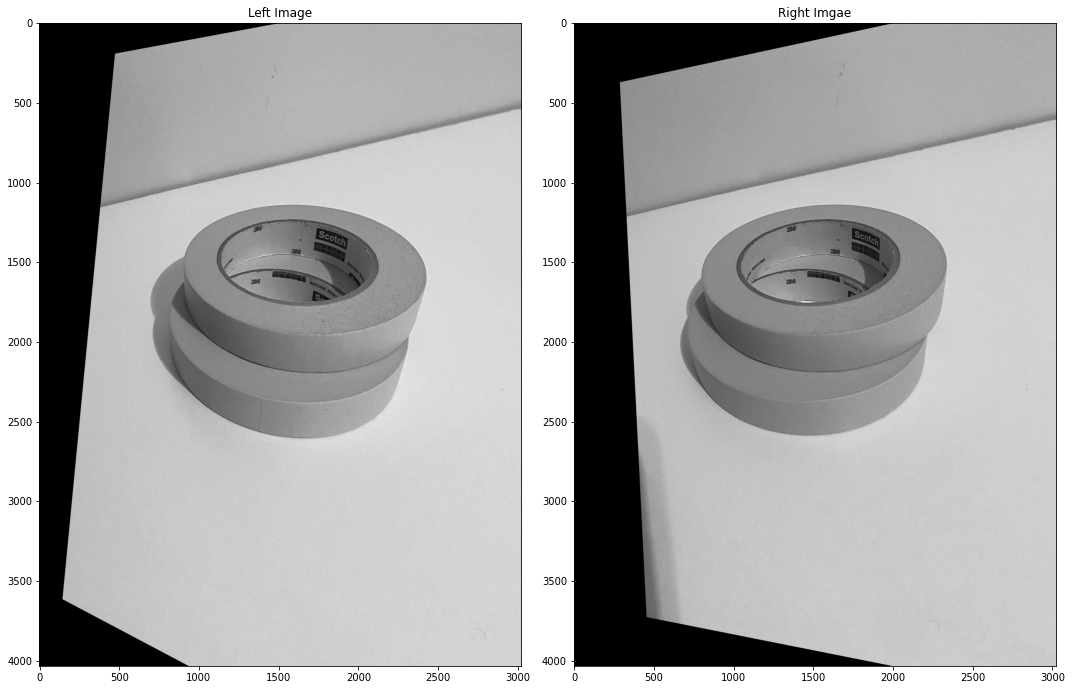

In [759]:
out = ImgRectification(img1, img2)
PltImg(out, imgDescipt_1)

<Figure size 1800x1200 with 0 Axes>

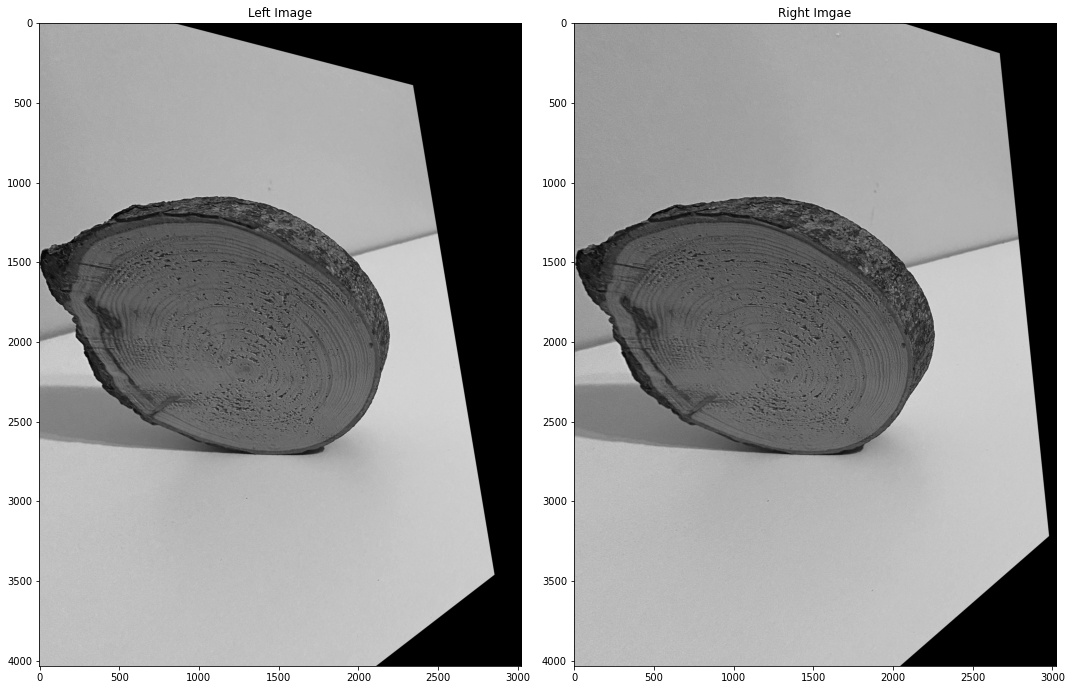

In [760]:

out2 = ImgRectification(img3, img4)
PltImg(out2, imgDescipt_1)

<Figure size 1800x1200 with 0 Axes>

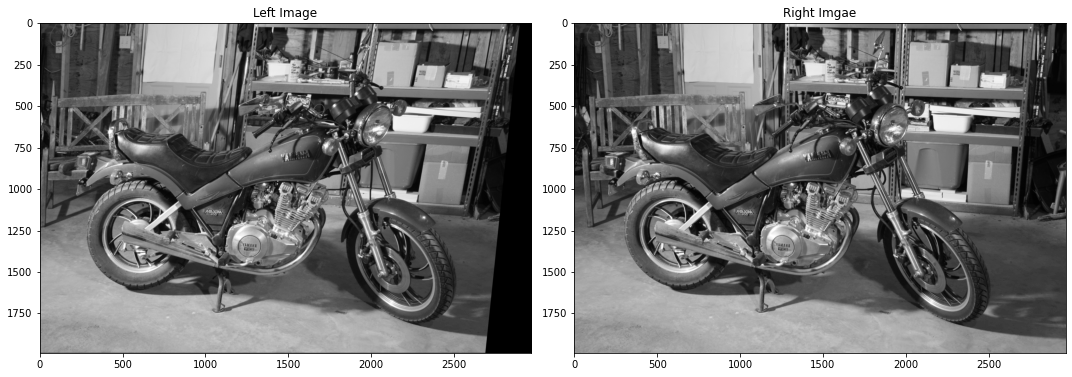

In [761]:
out3 = ImgRectification(img5, img6)
PltImg(out3, imgDescipt_1)

# 1.3

In [762]:
def BlockMatchingDisparity(outs, numDispar, bSize):
    # outImg = ImgRectification(img1, img2)
    my_stereo_instance = cv.StereoBM_create(numDisparities = numDispar, blockSize = bSize)
    outImg = my_stereo_instance.compute(outs[0], outs[1])
    PltImg([outImg],"Block Matching Disparity Map")
    return outImg

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

<Figure size 1800x1200 with 0 Axes>

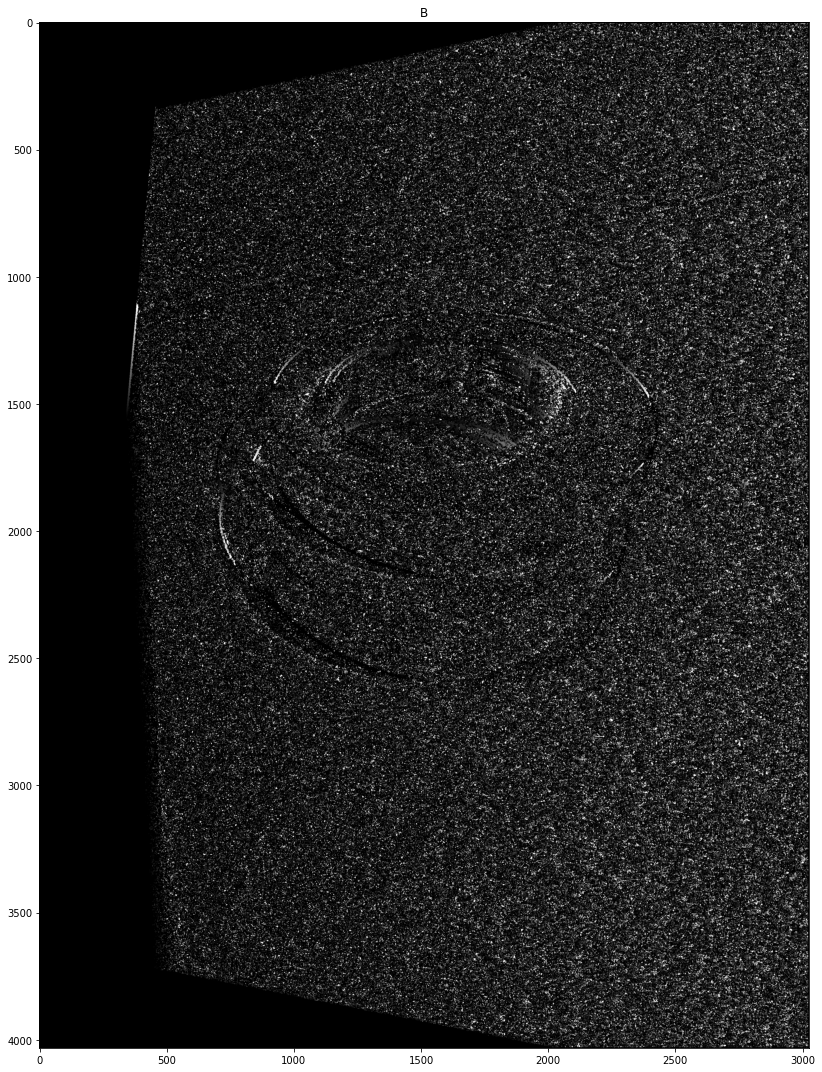

In [763]:
BlockMatchingDisparity(out, 64,   7)

In [764]:

BlockMatchingDisparity(out2, 64,    9)

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

<Figure size 1800x1200 with 0 Axes>

In [765]:
BlockMatchingDisparity(out3, 128, 39)

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

<Figure size 1800x1200 with 0 Axes>

# 1.2 Horizontal test

In [766]:
def EpipolarDrawLine(img1, lines, leftPoint, rightPoint, flag): #flag == 1 is dealing set of points , flag == 0 is dealing with one point
    col = img1.shape[1]
    outImg = np.copy(img1)
    rdColor = (0,255,0)
    for line, lpt in zip(lines, leftPoint):
        line = line[0]
        x1,y1 = [0, int(-line[2]/line[1])]  #NOTE: calculate bound points 
        x2,y2 = [col, int(-(line[2]+line[0]*col)/line[1])]
        if flag == 1:
            rdColor = tuple(np.random.randint(0,255,size = 3).tolist())
            outImg = cv.circle(outImg, tuple(lpt[0]), 5, rdColor, -1)
        outImg = cv.line(outImg, (x1,y1), (x2,y2), rdColor, thickness = 1)
    return outImg

def EpipolarLineCal(img1, img2):
    point1 = []
    point2 = []
    pltImage1 = []
    _,_,_,point1,point2 = Matching(img1, img2, flag = 0)
    point1 = np.int32(point1)
    point2 = np.int32(point2)
    F, mask = cv.findFundamentalMat(point1, point2, cv.FM_LMEDS)
    
    # point1 = point1[mask.ravel()==1] #this method works as well, turn matrix into 1 dimension 
    point1 = point1[mask.reshape(-1)==1].reshape(-1,1,2)    #NOTE: use mask to filter left and right points 
    point2 = point2[mask.reshape(-1)==1].reshape(-1,1,2)
    
    line1 = cv.computeCorrespondEpilines(point2, 2, F)
    line2 = cv.computeCorrespondEpilines(point1, 1, F)
    outImg1 = EpipolarDrawLine(img1, line1, point1, point2, flag = 0)
    outImg2 = EpipolarDrawLine(img2, line2, point2, point1, flag = 0)
    
    pltImage1.append(outImg1)
    pltImage1.append(outImg2)
    PltImg(pltImage1,["Left", "right"])
    return pltImage1

[array([[ 41,  42,  43, ...,   0,   0,   0],
        [ 45,  46,  47, ...,   0,   0,   0],
        [ 51,  51,  51, ...,   0,   0,   0],
        ...,
        [147, 146, 144, ...,   0,   0,   0],
        [147, 145, 143, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 array([[ 45,  45,  45, ...,  10,   9,   9],
        [ 46,  47,  47, ...,  10,   9,   9],
        [ 49,  51,  51, ...,  10,   9,   9],
        ...,
        [153, 154, 153, ..., 145, 145, 145],
        [151, 152, 151, ..., 145, 144, 144],
        [149, 149, 148, ..., 144, 143, 143]], dtype=uint8)]

<Figure size 1800x1200 with 0 Axes>

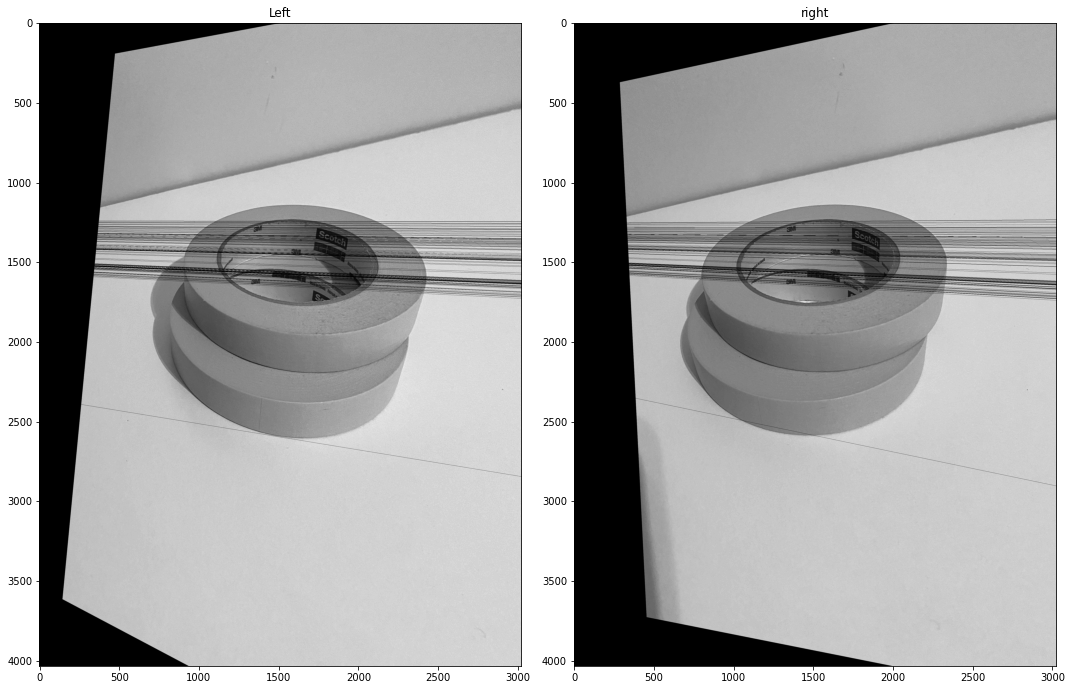

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

In [767]:
EpipolarLineCal(out[0],out[1])
EpipolarLineCal(out2[0],out2[1])
EpipolarLineCal(out3[0],out3[1])